In [1]:
import numpy as np
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import json

# Preparation

In [2]:
MODEL_FILEDIR = '/scratch/data/TrojAI/image-classification-sep2022-train/models/'
METADATA_FILEPATH = '/scratch/data/TrojAI/image-classification-sep2022-train/METADATA.csv'
MODEL_ARCH = ['classification:' + arch for arch in ['resnet50', 'vit_base_patch32_224', 'mobilenet_v2']]
NUM_MODEL = 288
OUTPUT_FILEDIR = '/scratch/jialin/image-classification-sep2022/projects/weight_analysis/extracted_source/'


def num_to_model_id(num):
    return 'id-' + str(100000000+num)[1:]

# Load Metadata

In [3]:
METADATA = pd.read_csv(METADATA_FILEPATH)
METADATA.head()

,model_name,converged,nonconverged_reason,master_seed,task_type_level,task_type,source_dataset_level,source_dataset,model_architecture,model_architecture_level,...,trigger_2.trigger_size_restriction_option,trigger_2.polygon_texture_augmentation_level,trigger_2.polygon_texture_augmentation,trigger_2.size_percentage_of_foreground_min,trigger_2.size_percentage_of_foreground_max,trigger_2.min_area,trigger_2.spatial_quadrant_level,trigger_2.spatial_quadrant,trigger_2.options_level,trigger_2.options
0,id-00000000,True,NaN,354103127,0,classification,0,cityscapes,classification:resnet50,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,id-00000001,True,NaN,2049821827,0,classification,0,cityscapes,classification:vit_base_patch32_224,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,id-00000002,True,NaN,74361305,0,classification,0,cityscapes,classification:mobilenet_v2,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,id-00000003,True,NaN,197593124,0,classification,0,cityscapes,classification:resnet50,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,id-00000004,True,NaN,69550395,0,classification,0,cityscapes,classification:resnet50,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Feature Extraction

## Aggregated Weight

In [2]:
def extract_weight(model):
    params = []
    for param in model.parameters():
        if len(param.shape)>2:
            axis = tuple(np.arange(len(param.shape)-1).tolist())
            params += torch.amax(param, dim=axis).flatten().tolist()
            params += torch.mean(param, dim=axis).flatten().tolist()
            sub = torch.mean(param, dim=axis).flatten() - torch.median(torch.flatten(param, end_dim=-2), dim=0).values.flatten()
            params += sub.tolist()
            params += torch.median(torch.flatten(param, end_dim=-2), dim=0).values.flatten().tolist()
            params += torch.sum(param, dim=axis).flatten().tolist()
            params += (torch.linalg.norm(param, ord='fro', dim=axis).flatten()**2/torch.linalg.norm(param, ord=2, dim=axis).flatten()**2).tolist()
        else:
            params.append(param.max().tolist())
            params.append(param.mean().tolist())
            sub = param.mean() - torch.median(param)
            params.append(sub.tolist())
            params.append(torch.median(param).tolist())
            params.append(param.sum().tolist())
            params.append((torch.linalg.norm(param.reshape(param.shape[0], -1), ord='fro')**2/torch.linalg.norm(param.reshape(param.shape[0], -1), ord=2)**2).tolist())
    return np.asarray(params)

## Weight from round-10

In [25]:
def _get_weight_features(model):
    params = []
    for param in model.parameters():
        if len(param.shape)>2:
            axis = tuple(np.arange(len(param.shape)-1).tolist())
            params += torch.amax(param, dim=axis).flatten().tolist()
            params += torch.mean(param, dim=axis).flatten().tolist()
            sub = torch.mean(param, dim=axis).flatten() - torch.median(torch.flatten(param, end_dim=-2), dim=0).values.flatten()
            params += sub.tolist()
            params += torch.median(torch.flatten(param, end_dim=-2), dim=0).values.flatten().tolist()
            params += torch.sum(param, dim=axis).flatten().tolist()
            # params += (torch.linalg.norm(param, ord='fro', dim=axis).flatten()**2/torch.linalg.norm(param, ord=2, dim=axis).flatten()**2).tolist()
    return np.asarray(params)

## Eigen Value

In [3]:
def extract_eigen(model):
    params = []
    num_param_per_layer = []
    min_shape = 1
    for param in model.parameters():
        if len(param.shape) > min_shape:
            reshaped_param = param.reshape(param.shape[0], -1)
            singular_values = torch.linalg.svd(reshaped_param, False).S
            squared_singular_values = torch.square(singular_values)
            ssv = squared_singular_values.tolist()
            params += ssv
            num_param_per_layer.append(len(ssv))
    return np.asarray(params), np.asarray(num_param_per_layer)

In [10]:
def explore_eigen(model):
    params = []
    num_param_per_layer = []
    min_shape = 2
    for param in model.parameters():
        if len(param.shape) > min_shape:
            if param.shape[-1] == param.shape[-2]:
                reshaped_param = param
            else:
                reshaped_param = param.reshape(param.shape[0], -1)
            singular_values = torch.linalg.svd(reshaped_param, False).S
            squared_singular_values = torch.square(singular_values)
            ssv = squared_singular_values.flatten().tolist()
            params += ssv
            num_param_per_layer.append(len(ssv))
    return np.asarray(params), np.asarray(num_param_per_layer)

In [7]:
def extract_optimal_layer_eigen(model, optimal_layers=[]):
    eigens = []
    min_shape, layer_num = 1, 0
    for param in model.parameters():
        if len(param.shape) > min_shape:
            layer_num += 1
            if layer_num in optimal_layers:
                reshaped_param = param.reshape(param.shape[0], -1)
                singular_values = torch.linalg.svd(reshaped_param, False).S
                squared_singular_values = torch.square(singular_values)
                ssv = squared_singular_values.tolist()
                eigens += ssv
    eigens = np.array_split(eigens, 120)
    params = []
    for eig in eigens:
        if eig.shape[-1] != 0:
            params.append(eig.max())
            params.append(eig.mean())
            params.append((eig.mean() - np.median(eig)))
            params.append(np.median(eig))
            params.append(eig.sum())
    return np.stack(params)

## Directly load without saving locally

In [ ]:
optimal_layers = {'classification:resnet50': [48, 49], 'classification:vit_base_patch32_224': [2, 25], 'classification:mobilenet_v2': [35,  7]}
weight_with_eigen = {ma:[] for ma in MODEL_ARCH}
for num in tqdm(range(NUM_MODEL)):
    model_id = num_to_model_id(num)
    model_filepath = os.path.join(MODEL_FILEDIR, model_id, 'model.pt')
    with torch.no_grad():
        model = torch.load(model_filepath)
    metadata_of_model = METADATA[METADATA['model_name'] == model_id]
    model_arch = metadata_of_model['model_architecture'].item()
    weights = extract_weight(model)
    eigens = extract_optimal_layer_eigen(model, optimal_layers=optimal_layers[model_arch])
    weight_with_eigen[model_arch].append(np.append(weights[:-1], eigens))

In [11]:
from itertools import product

eig_df = {ma+eol:[] for ma, eol in list(product(MODEL_ARCH, ['_eigen', '_layer', '_label']))}
for num in tqdm(range(NUM_MODEL)):
    model_id = num_to_model_id(num)
    model_filepath = os.path.join(MODEL_FILEDIR, model_id, 'model.pt')
    with torch.no_grad():
        model = torch.load(model_filepath)
    params, pnum_per_layer = explore_eigen(model)
    metadata_of_model = METADATA[METADATA['model_name'] == model_id]
    model_arch = metadata_of_model['model_architecture'].item()
    poisoned = metadata_of_model['poisoned'].item()
    eig_df[model_arch+'_eigen'].append(params)
    eig_df[model_arch+'_layer'].append(pnum_per_layer)
    eig_df[model_arch+'_label'].append(poisoned)

100%|██████████| 288/288 [4:02:39<00:00, 50.55s/it]  


In [12]:
for k, v in eig_df.items():
    np.save(os.path.join(OUTPUT_FILEDIR, 'new_eigens', f'{k}.npy'), np.asarray(v))

In [4]:
from itertools import product

def load_model_params_to_df(metadata=METADATA, extraction_method=extract_weight, model_filedir=MODEL_FILEDIR):
    df_by_model_type = {model_arch:[] for model_arch in MODEL_ARCH}

    for num in tqdm(range(NUM_MODEL)):
        model_id = num_to_model_id(num)
        model_filepath = os.path.join(model_filedir, model_id, 'model.pt')
        with torch.no_grad():
            model = torch.load(model_filepath)
        metadata_of_model = metadata[metadata['model_name'] == model_id]
        model_arch = metadata_of_model['model_architecture'].item()
        poisoned = metadata_of_model['poisoned'].item()
        if extraction_method == extract_weight or _get_weight_features:
            params = extraction_method(model).tolist()
        elif extraction_method == extract_eigen:
            params, pnum_per_layer = extraction_method(model)
            pnum_df = pd.DataFrame([pnum_per_layer])
            pnum_df['model_num'] = model_id
            pnum_kname = model_arch+'_'+'pnum'
            if pnum_kname in df_by_model_type:
                df_by_model_type[pnum_kname].append(pnum_df)
            else:
                df_by_model_type[pnum_kname] = [pnum_df]

        df = pd.DataFrame([params])
        df['model_num'] = model_id
        df['model_arch'] = model_arch
        df['poisoned'] = poisoned

        df_by_model_type[model_arch].append(df)
    
    for k, v in df_by_model_type.items():
        dataframe = pd.concat(v)
        df_by_model_type[k] = dataframe
    return df_by_model_type


NameError: name 'METADATA' is not defined

In [30]:
df_by_model_type = load_model_params_to_df(extraction_method=_get_weight_features)

100%|██████████| 288/288 [07:50<00:00,  1.63s/it]


In [31]:
for k, v in df_by_model_type.items():
    print(f'{k} -- {v.shape}')

classification:resnet50 -- (96, 458)
classification:vit_base_patch32_224 -- (96, 7843)
classification:mobilenet_v2 -- (96, 443)


In [13]:
for k, v, in df_by_model_type.items():
    if 'pnum' in k:
        v.to_csv(os.path.join(OUTPUT_FILEDIR, k[15:]+'.csv'))
    else:
        v.to_csv(os.path.join(OUTPUT_FILEDIR, k[15:]+'_'+'eigen.csv'))

# Feature Mixup

In [16]:
weight_eigen_filedir = '/scratch/jialin/image-classification-sep2022/projects/weight_analysis/for_container/learned_parameters'
weight_eigen_dict = {}
for ma in MODEL_ARCH:
    X = np.load(os.path.join(weight_eigen_filedir, f'train_X_{ma[15:]}.npy'))
    y = np.load(os.path.join(weight_eigen_filedir, f'train_y_{ma[15:]}.npy'))
    weight_eigen_dict[ma] = (X, y)

In [17]:
for ma in MODEL_ARCH:
    print(weight_eigen_dict[ma][0].shape, weight_eigen_dict[ma][1].shape)

(96, 1248) (96,)
(96, 1184) (96,)
(96, 1225) (96,)


In [18]:
def mixup_data(X, y, lam=0, lo=.6, hi=.95):
    assert len(y.shape) == 1 and len(X.shape) == 2
    lam = np.random.uniform(lo, hi)
    mixup_ind = {'trojan': np.nonzero(y), 
                  'clean': np.nonzero(y == 0)}
    ret_X, ret_y = [X], [y]
    for cot in ['trojan', 'clean']:
        ind = mixup_ind[cot][0]
        mixed_X, mixed_y = X[ind, :], y[ind]
        mixed_ind = np.random.permutation(ind.shape[0])
        ret_X.append(lam * mixed_X + (1-lam) * mixed_X[mixed_ind, :])
        ret_X.append(lam * mixed_X[mixed_ind, :] + (1-lam) * mixed_X)
        ret_y.append(mixed_y)
        ret_y.append(mixed_y)
    ret_X = np.concatenate(ret_X, axis=0)
    ret_y = np.concatenate(ret_y)
    return ret_X, ret_y, lam

In [ ]:
LAMBDA_DICT = {ma:lmbda for ma, lmbda in zip(MODEL_ARCH, (0.6737022622237678, 0.7903979831170203, 0.85))}
EXPORTED_PATH = '/scratch/jialin/image-classification-sep2022/projects/weight_analysis/extracted_source/mixedup_weight_eigen_stats/'
for ma in MODEL_ARCH[2]:
    X, y, lmbda = mixup_data(*weight_eigen_dict[ma], lam = LAMBDA_DICT[ma])
    print(X.shape, y.shape, lmbda)
    np.save(os.path.join(EXPORTED_PATH, f'train_X_{ma[15:]}.npy'), X)
    np.save(os.path.join(EXPORTED_PATH, f'train_y_{ma[15:]}.npy'), y)

In [34]:
from sklearn.metrics import log_loss
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

clf_dict = {MODEL_ARCH[0]: GradientBoostingClassifier(learning_rate=0.015, n_estimators=900, max_depth=3, min_samples_split=24, min_samples_leaf=16, max_features=120),
            MODEL_ARCH[1]: GradientBoostingClassifier(learning_rate=0.01, n_estimators=750, max_depth=3, min_samples_split=40, min_samples_leaf=4, max_features=32),
            MODEL_ARCH[2]: GradientBoostingClassifier(learning_rate=0.011, n_estimators=500, max_depth=4, min_samples_split=34, min_samples_leaf=16, max_features=96)}

best_cen_X, best_cen_y = None, None
best_cen = 1e8
N = 50
result_dict = {}
for ma in tqdm(MODEL_ARCH[2:]):
    all_cross_entropy, all_accuracy, all_lambd = [], [], []
    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(*weight_eigen_dict[ma], test_size=.2)
        X_train, y_train, lambd = mixup_data(X_train, y_train, lo=.35, hi=.95)
        clf = clf_dict[ma]
        clf.set_params(random_state=i)            
        clf.fit(X_train, y_train)

        ll, sc = log_loss(y_test, clf.predict_proba(X_test), eps=.01), clf.score(X_test, y_test)
        all_cross_entropy.append(ll)
        all_accuracy.append(sc)
        all_lambd.append(lambd)

        if ll < best_cen:
            best_cen = ll
            X_test, y_test, _ = mixup_data(X_test, y_test, lam=lambd)
            best_cen_X, best_cen_y = np.concatenate([X_train, X_test], axis=0), np.concatenate([y_train, y_test], axis=0)
        
    result_dict[ma] = (all_cross_entropy, all_accuracy, all_lambd)
    print(f'{ma[15:]}: cen - {np.mean(all_cross_entropy)}, acc - {np.mean(all_accuracy)}')

100%|██████████| 1/1 [02:02<00:00, 122.39s/it]

mobilenet_v2: cen - 0.4431493080578334, acc - 0.7939999999999999


In [38]:
best_cen_X.shape, best_cen_y.shape

((288, 1225), (288,))

In [43]:
np.save('/scratch/jialin/image-classification-sep2022/projects/weight_analysis/for_container/best_cen_X.npy', best_cen_X)
np.save('/scratch/jialin/image-classification-sep2022/projects/weight_analysis/for_container/best_cen_y.npy', best_cen_y)

In [37]:
result_dict[MODEL_ARCH[2]][0][29], result_dict[MODEL_ARCH[2]][1][29], best_cen

(0.23564567292736122, 0.95, 0.23564567292736122)

In [35]:
np.argsort(result_dict[MODEL_ARCH[2]][0])

array([29, 10, 44, 41, 30, 32, 28,  4,  8, 46,  7, 42, 16, 11,  1, 49, 40,
        3, 18, 47, 27,  9, 12, 45, 17, 21, 15,  6, 35, 23, 24, 13,  0, 22,
       33, 38,  5, 34, 48, 14, 26, 39, 37, 31, 19,  2, 43, 20, 25, 36])

In [36]:
np.argsort(result_dict[MODEL_ARCH[2]][1])[::-1]

array([28, 29, 10, 17, 44, 30, 41,  4,  0,  9, 32, 12,  8, 18,  7, 45, 46,
       47, 26,  6, 15,  3, 16,  2, 49, 34, 39, 37, 14,  1, 42, 40, 38, 35,
       11, 24, 33, 27, 21, 22, 13, 23, 36, 25, 19,  5, 20, 48, 31, 43])

In [12]:
N = 50
non_mixup_result_dict = {}
for ma in tqdm(MODEL_ARCH):
    cen, acc = bootstrap_performance(*weight_eigen_dict[ma], clf_dict[ma], n=N)
    non_mixup_result_dict[ma] = (cen, acc)
    print(f'{ma[15:]}: cen - {np.mean(cen)}, acc - {np.mean(acc)}')

 33%|███▎      | 1/3 [01:14<02:28, 74.26s/it]

resnet50: cen - 0.33471937046065053, acc - 0.853


 67%|██████▋   | 2/3 [01:28<00:38, 38.75s/it]

vit_base_patch32_224: cen - 0.43177496610104205, acc - 0.809


100%|██████████| 3/3 [01:40<00:00, 33.44s/it]

mobilenet_v2: cen - 0.5607166100285954, acc - 0.698


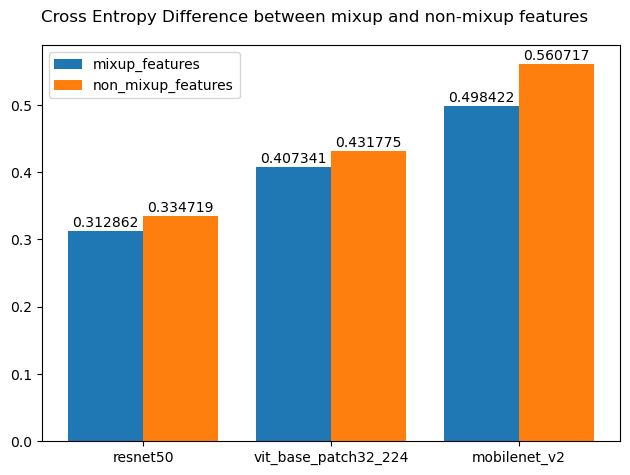

In [38]:
fig, ax = plt.subplots()
bar1 = ax.bar(np.arange(3)-.2, [np.mean(result_dict[ma][0]) for ma in MODEL_ARCH], width=0.4, label='mixup_features')
bar2 = ax.bar(np.arange(3)+.2, [np.mean(non_mixup_result_dict[ma][0]) for ma in MODEL_ARCH], width=0.4, label='non_mixup_features')
ax.set_xticks(np.arange(3), [ma[15:] for ma in MODEL_ARCH])
ax.legend()
ax.bar_label(bar1, padding=1)
ax.bar_label(bar2, padding=1)
plt.suptitle('Cross Entropy Difference between mixup and non-mixup features')
fig.tight_layout()
plt.show()

# Visualization

In [4]:
from sklearn.metrics import log_loss
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

def bootstrap_performance(X, y, clf, n=10, test_size=.2, eps=.01):
    all_cross_entropy, all_accuracy = [], []
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=i)
        
        clf.set_params(random_state=i)            
        clf.fit(X_train, y_train)
        
        all_cross_entropy.append(log_loss(y_test, clf.predict_proba(X_test), eps=eps))
        all_accuracy.append(clf.score(X_test, y_test))
    return all_cross_entropy, all_accuracy

### Eigen Value Analysis

In [5]:
layer_data = {ma: np.cumsum(pd.read_csv(os.path.join(OUTPUT_FILEDIR, f'{ma[15:]}_pnum.csv')).iloc[:, 1:-1].to_numpy(), axis=1)[0][:-1] for ma in MODEL_ARCH}
eigen_data = {ma: pd.read_csv(os.path.join(OUTPUT_FILEDIR, f'{ma[15:]}_eigen.csv')).iloc[:, 1:].to_numpy() for ma in MODEL_ARCH}
label_data = {ma: pd.read_csv(os.path.join(OUTPUT_FILEDIR, f'{ma[15:]}_eigen.csv'))['poisoned'] for ma in MODEL_ARCH}
split_eigen_data = {ma: np.split(eigen_data[ma], layer_data[ma], axis=1)[:-1] for ma in MODEL_ARCH}

In [7]:
NEW_EIGEN_FILEDIR = os.path.join(OUTPUT_FILEDIR, 'new_eigens')
layer_data = {ma: np.cumsum(np.load(os.path.join(NEW_EIGEN_FILEDIR, f'{ma}_layer.npy')), axis=1)[0][:-1] for ma in MODEL_ARCH}
eigen_data = {ma: np.load(os.path.join(NEW_EIGEN_FILEDIR, f'{ma}_eigen.npy')) for ma in MODEL_ARCH}
label_data = {ma: np.load(os.path.join(NEW_EIGEN_FILEDIR, f'{ma}_label.npy')) for ma in MODEL_ARCH}
split_eigen_data = {ma: np.split(eigen_data[ma], layer_data[ma], axis=1)[:-1] for ma in MODEL_ARCH}

In [6]:
agg_eigen_data = {ma: np.concatenate([np.stack([sed.max(axis=1), sed.mean(axis=1), sed.mean(axis=1)-np.median(sed, axis=1), np.median(sed, axis=1), sed.sum(axis=1)], axis=1) for sed in split_eigen_data[ma]], axis=1) for ma in MODEL_ARCH}

In [7]:
for ma in MODEL_ARCH:
    print(agg_eigen_data[ma].shape)

(96, 265)
(96, 255)
(96, 260)


In [6]:
with open(os.path.join(OUTPUT_FILEDIR, 'eigen_val_result.json'), 'r') as outfile:
    result = json.load(outfile)

In [7]:
optimal_layers, optimal_eigen_data = {}, {}
for ma in MODEL_ARCH:
    acc = [res[1] for res in result[ma]]
    layers = np.argsort(acc)[::-1][:2]
    optimal_layers[ma] = layers
    opt_split_data = np.array_split(np.concatenate([split_eigen_data[ma][layer] for layer in layers], axis=1), 120, axis=1)
    params = []
    for param in opt_split_data:
        if param.shape[-1] != 0:
            params.append(param.max(axis=1))
            params.append(param.mean(axis=1))
            params.append((param.mean(axis=1) - np.median(param, axis=1)))
            params.append(np.median(param, axis=1))
            params.append(param.sum(axis=1))
    optimal_eigen_data[ma] = np.stack(params, axis=1)

In [39]:
for ma in MODEL_ARCH:
    print(optimal_eigen_data[ma].shape)

(96, 600)
(96, 600)
(96, 525)


In [22]:
optimal_layers

{'classification:resnet50': array([48, 49]),
 'classification:vit_base_patch32_224': array([ 2, 25]),
 'classification:mobilenet_v2': array([35,  7])}

In [ ]:
N = 30
eigen_per_layer_result = {ma:[] for ma in MODEL_ARCH}
for ma in MODEL_ARCH:
    eigen_per_layer = split_eigen_data[ma]
    label = label_data[ma]
    result_per_layer = []
    for epl in tqdm(eigen_per_layer):
        cen, acc = bootstrap_performance(epl, label, clf_dict[ma], n=N)
        eigen_per_layer_result[ma].append((np.mean(cen), np.mean(acc)))

In [26]:
with open(os.path.join(NEW_EIGEN_FILEDIR, 'eigen_val_result.json'), 'w') as outfile:
    json.dump(eigen_per_layer_result, outfile)

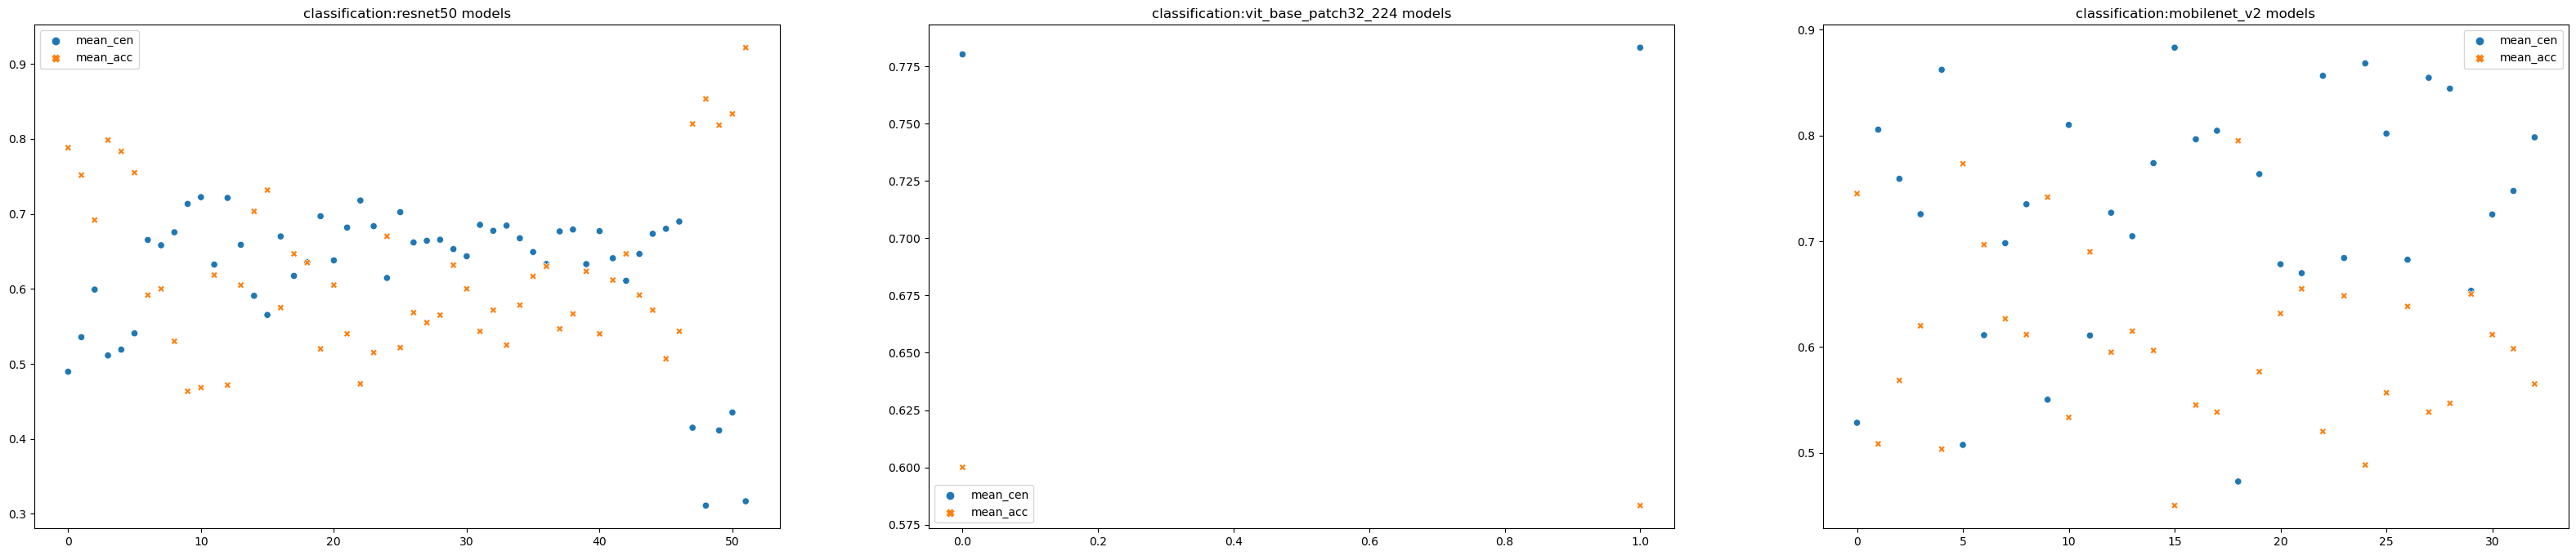

In [6]:
# sns.set(rc={'figure.figsize':(16,30)});
NEW_EIGEN_FILEDIR = os.path.join(OUTPUT_FILEDIR, 'new_eigens')
with open(os.path.join(NEW_EIGEN_FILEDIR, 'eigen_val_result.json'), 'r') as outfile:
    result = json.load(outfile)
fig, axs = plt.subplots(ncols=3, figsize=(40, 8))
for ind, ax in enumerate(axs):
    df = pd.DataFrame(result[MODEL_ARCH[ind]])
    df.columns = ['mean_cen', 'mean_acc']
    sns.scatterplot(data=df, ax=ax);
    ax.set_title(MODEL_ARCH[ind]+' models')

# Tune/Train Models

In [4]:
OUTPUT_FILEDIR = '/scratch/jialin/image-classification-sep2022/projects/weight_analysis/extracted_source/'
weights = {ma: pd.read_csv(os.path.join(OUTPUT_FILEDIR, ma[15:]+'_weight.csv')).iloc[:, 1:-3].to_numpy() for ma in MODEL_ARCH}
weights_label = {ma: pd.read_csv(os.path.join(OUTPUT_FILEDIR, ma[15:]+'_weight.csv'))['poisoned'] for ma in MODEL_ARCH}

In [9]:
for ma in MODEL_ARCH:
    print(np.concatenate([weights[ma], agg_eigen_data[ma]], axis=1).shape)

(96, 1231)
(96, 1167)
(96, 1208)


In [34]:
weights_3d = {ma: df_by_model_type[ma].iloc[:, :-3].to_numpy() for ma in MODEL_ARCH}
weights_3d_label = {ma: df_by_model_type[ma]['poisoned'] for ma in MODEL_ARCH}

In [5]:
EXTRACTED_FILEDIR = '/scratch/jialin/image-classification-sep2022/projects/weight_analysis/extracted_source/prev_learned_param/'
learned_features = {}
for model_arch in MODEL_ARCH:
    ma = model_arch[15:]
    X, y = np.load(os.path.join(EXTRACTED_FILEDIR, f'train_X_{ma}.npy')), np.load(os.path.join(EXTRACTED_FILEDIR, f'train_y_{ma}.npy'))
    learned_features[model_arch] = (X, y)

In [31]:
extracted_mixedup = '/scratch/jialin/image-classification-sep2022/projects/weight_analysis/for_container/learned_parameters'
for ma in MODEL_ARCH:
    X = np.load(os.path.join(extracted_mixedup, f'train_X_{ma[15:]}.npy'))
    y = np.load(os.path.join(extracted_mixedup, f'train_y_{ma[15:]}.npy'))
    print(ma, X.shape, y.shape)

classification:resnet50 (96, 1236) (96,)
classification:vit_base_patch32_224 (288, 1172) (288,)
classification:mobilenet_v2 (288, 1213) (288,)


In [8]:
clf_dict = {MODEL_ARCH[0]: GradientBoostingClassifier(learning_rate=0.015, n_estimators=900, max_depth=3, min_samples_split=24, min_samples_leaf=16, max_features=120),
            MODEL_ARCH[1]: GradientBoostingClassifier(learning_rate=0.01, n_estimators=750, max_depth=3, min_samples_split=40, min_samples_leaf=4, max_features=32),
            MODEL_ARCH[2]: GradientBoostingClassifier(learning_rate=0.011, n_estimators=500, max_depth=4, min_samples_split=34, min_samples_leaf=16, max_features=96)}
# only_weights = {ma: ind for ma, ind in list(zip(MODEL_ARCH, [-600, -600, -525]))}

In [9]:
# LEARNED_PARAM = '/scratch/jialin/image-classification-sep2022/projects/weight_analysis/for_container/learned_parameters'
LEARNED_PARAM = '/scratch/jialin/image-classification-sep2022/projects/weight_analysis/extracted_source/weight_eigen_stats'
features = {}
for model_arch in MODEL_ARCH:
    features[model_arch] = (np.load(os.path.join(LEARNED_PARAM, f'train_X_{model_arch[15:]}.npy')), np.load(os.path.join(LEARNED_PARAM, f'train_y_{model_arch[15:]}.npy')))    

In [47]:
import joblib
for model_arch in MODEL_ARCH:
    clf = clf_dict[model_arch].fit(*features[model_arch])
    joblib.dump(clf, os.path.join(LEARNED_PARAM, f'original_{model_arch[15:]}_clf.joblib'))

In [41]:
N = 50
# clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.002)
result = []
for ma in MODEL_ARCH:
    result += list(bootstrap_performance(*features[ma], clf_dict[ma], n=N))
# [0.34988044 0.862      0.38599185 0.832      0.50996589 0.76      ]

In [42]:
res_arr = np.mean(result, axis=1)
res_pd = pd.DataFrame({'cross_entropy': [res_arr[i] for i in range(len(res_arr)) if i % 2 == 0],
                        'accuracy': [res_arr[i] for i in range(len(res_arr)) if i % 2 == 1]})
res_pd.index = [model_arch[15:] for model_arch in MODEL_ARCH]
res_pd

,cross_entropy,accuracy
resnet50,0.350309,0.872
vit_base_patch32_224,0.390434,0.832
mobilenet_v2,0.495690,0.777


In [11]:
from sklearn.model_selection import GridSearchCV

In [14]:
ma = MODEL_ARCH[1]
clf = clf_dict[ma]
# 
# param={'max_depth': range(3, 5), 'min_samples_split': range(12, 65, 4), 'min_samples_leaf': range(4, 33, 2), 'max_features': range(20, 101, 4)}
# param = {'learning_rate':np.arange(.001, .0351, .002), 'n_estimators':range(300, 1600, 25)}
param = {'learning_rate':[.01, .005, .015, .03, .0075], 'n_estimators':[650, 1300, 450, 225, 900]}
# gsearch = GridSearchCV(estimator=clf, param_grid=param, scoring=['neg_log_loss', 'accuracy'], n_jobs=10, cv=5, refit=False);
gsearch = GridSearchCV(estimator=clf, param_grid=param, scoring='neg_log_loss', n_jobs=10, cv=5);
gsearch.fit(features[ma][0], features[ma][1]);

In [15]:
gsearch.best_params_

{'learning_rate': 0.0075, 'n_estimators': 1300}

In [ ]:
gsearch = pd.DataFrame(gsearch.cv_results_).sort_values(by=['rank_test_neg_log_loss', 'rank_test_accuracy'])
gsearch.to_csv(os.path.join(OUTPUT_FILEDIR, 'gsearch_result.csv'))

### Generate json schema (without automatic_training param)

In [ ]:
TUNABLE_PARAMS = ['learning_rate', 'n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features']
param_dict = {}
for ma in MODEL_ARCH:
    p_dict = {f"{ma[15:]}_{k}": v for k, v in clf_dict[ma].get_params().items() if k in TUNABLE_PARAMS}
    param_dict = {**p_dict, **param_dict}
param_dict

In [ ]:
MIN_VAL, MAX_VAL = [0.001, 1, 1, 2, 1, 1], [1, 3000, 10, 1000, 1000, 1100]
SMIN_VAL, SMAX_VAL = [0.005, 100, 2, 10, 2, 20], [0.05, 1200, 5, 50, 25, 220]
keys = ['minimum', 'maximum', 'suggested_minimum', 'suggested_maximum']
DESC_VAL = {}
for key, val in zip(keys, [MIN_VAL, MAX_VAL, SMIN_VAL, SMAX_VAL]):
    val_dict = {k:v for k, v in zip(TUNABLE_PARAMS, val)}
    DESC_VAL[key] = val_dict
desc_dict = {}
for ma in MODEL_ARCH:
    for k, v in clf_dict[ma].get_params().items():
        baseline_desc = {}
        if k in TUNABLE_PARAMS:
            baseline_desc['description'] = f'Tunable parameter {k} in sklearn Gradient Boosting Classifier for model architecture {ma}'
            baseline_desc['type'] = 'number' if k == 'learning_rate' else 'integer'
            for key in keys:
                baseline_desc[key] = DESC_VAL[key][k]
            desc_dict[f'{ma[15:]}_{k}'] = baseline_desc

with open(os.path.join(EXTRACTED_FILEDIR, 'json_vals.json'), 'w') as outfile:
    json.dump(desc_dict, outfile)

In [6]:
import joblib

joblib.dump(None, '/scratch/jialin/image-classification-sep2022/projects/weight_analysis/src/none.joblib')

['/scratch/jialin/image-classification-sep2022/projects/weight_analysis/src/none.joblib']

In [7]:
model = joblib.load('/scratch/jialin/image-classification-sep2022/projects/weight_analysis/src/none.joblib')
model.predict_proba([[1, 2, 3]])

AttributeError: 'NoneType' object has no attribute 'predict_proba'